In [1]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:95% !important;} </style>"))

%load_ext autoreload
%autoreload 2

In [26]:
import os
import re
import pandas as pd
import numpy as np
import shlex
from io import StringIO

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

In [3]:
from pyelegant.ElegantRun import ElegantRun
from pyelegant.SDDSTools.SDDS import SDDS, SDDSCommand
from pyelegant.SDDSTools.Utils import GenerateNDimCoordinateGrid

In [4]:
sif = "/home/mti/gitlab-hzb/containers/bin/pelegant.sif"

# Reproduce FODO

## Symplectic FODO

In [5]:
elements ={
    "QF":{
        "type" : "KQUAD",
        "L": 0.342,
        "K1": 0.49,
        "N_KICKS":16
    },
    "QD":{
        "type" : "KQUAD",
        "L": 0.668,
        "K1": -0.4999,
        "N_KICKS":16
    },
    "D":{
        "type" : "DRIF",
     "L":3.5805   
    },
    "W1": {
        "type": "WATCH",
        "filename":"\"%s-%03ld.w1\"",
        "mode": "coordinates"
    }
}

FODOstr = "! FODO cell used by Jernej Frank for studying TRIBs\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line = ["W1","QF","D","QD","D","QF"]
linestr = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

In [6]:
print(FODOstr)

! FODO cell used by Jernej Frank for studying TRIBs

QF    : KQUAD, L= 0.342000000000, K1= 0.490000000000, N_KICKS=16.000000000000
QD    : KQUAD, L= 0.668000000000, K1=-0.499900000000, N_KICKS=16.000000000000
D     : DRIF, L= 3.580500000000
W1    : WATCH, filename="%s-%03ld.w1", mode=coordinates

FODO  : LINE=(W1,QF,D,QD,D,QF)


In [7]:
with open("FODO_Jernej.lte","w") as f:
    f.write(FODOstr)

## Non-symplectic FODO

In [9]:
elements ={
    "QF":{
        "type" : "QUAD",
        "L": 0.342,
        "K1": 0.49,
#         "N_KICKS":16
    },
    "QD":{
        "type" : "QUAD",
        "L": 0.668,
        "K1": -0.4999,
#         "N_KICKS":16
    },
    "D":{
        "type" : "DRIF",
     "L":3.5805   
    },
    "W1": {
        "type": "WATCH",
        "filename":"\"%s-%03ld.w1\"",
        "mode": "coordinates"
    }
}

FODOstr = "! FODO cell used by Jernej Frank for studying TRIBs\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line = ["W1","QF","D","QD","D","QF"]
linestr = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

In [10]:
with open("FODO_Jernej_non_symplectic.lte","w") as f:
    f.write(FODOstr)

# Non-Symplectic Tracking

In [12]:
lattice = "FODO_Jernej_non_symplectic.lte"

er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
twidata, twipar = er.findtwiss()

# off - momentum
delta = 1.5e-3 * twipar.pCentral

# coordinate grid
man_ranges= {
    0 : np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0.05], #0.05
    2 : 0,#[.001,0.01,0.1,1,1.95,2],
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

# generate coordinate input file
er.generate_sdds_particle_inputfile(man_ranges=man_ranges)

# track
er.track_simple(n_passes=1000)

Shape: (24, 6) - Number of paritcles: 24 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
bash run_pelegant.sh
bash run_pelegant.sh temp.ele


In [17]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="-2.5,2.5,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
#     device="gif",
#     output="FODO_island_init_px_non_zero_non_symplectic.gif"
)


Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=-2.5,2.5,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=gif -output=FODO_island_init_px_non_zero_non_symplectic.gif


# Symplectic case

In [20]:
lattice = "FODO_Jernej.lte"

er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
twidata, twipar = er.findtwiss()


# off - momentum
delta = 1.5e-3 * twipar.pCentral


# coordinate grid around islands
man_ranges= {
    0 : np.linspace(1.7,2.0,100),#np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0.05], #0.05
    2 : 0,#[.001,0.01,0.1,1,1.95,2],
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

er.generate_sdds_particle_inputfile(man_ranges=man_ranges)

# track
er.track_simple(n_passes=25000)

Shape: (100, 6) - Number of paritcles: 100 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
bash run_pelegant.sh
bash run_pelegant.sh temp.ele


In [21]:
sddsp = SDDS(sif,"temp-001.w1",0)

# read data in dataframe
pdata = sddsp.readParticleData()
pdata = pdata.compute() # large file -> dask lazy dataframe laod it with compute - careful with memory!!!

False
temp-001.w1
temp-001.w1
['x', 'xp', 'y', 'yp', 't', 'p', 'dt', 'particleID']
Warning - auto filename set
Changed from temp-001.w1 to temp-001.w1.txt
Warning - auto filetype set
Changed from 0 to 1
File is large, output redirected to file temp-001.w1.txt_columnvalues.dat


In [24]:
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="gif",
    output="FODO_island_init_px_non_zero_symplectic.gif"
)


Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=gif -output=FODO_island_init_px_non_zero_symplectic.gif


## Tunes using FFT

In [36]:
tune = []
tuneis1 = []
tuneis2 = []
tuneis3 = []
tuneis4 = []
tuneis5 = []
action = []
ids=[]
for i, df in pdata.groupby("particleID"):
    data = df["x"]
    
    sp = np.fft.fft(data)
    freq = np.fft.fftfreq(len(data))
    
    tunedata = np.array(list(zip(freq,sp.real)))
    tunedata = tunedata[tunedata[:,0]>=0]
    
    sp = tunedata[:,1]
    freq = tunedata[:,0]
     
#     print(np.argsort((sp.real))[-5:])
#     print(sp.real[np.argsort((sp.real))[-5:]])
#     print(freq[np.argsort((sp.real))[-5:]])
#     print("---------------------------")
    tune.append(freq[np.argsort((sp.real))[-1]])
    tuneis1.append(freq[np.argsort((sp.real))[-2]])
    tuneis2.append(freq[np.argsort((sp.real))[-3]])
    tuneis3.append(freq[np.argsort((sp.real))[-4]])
    tuneis4.append(freq[np.argsort((sp.real))[-5]])
    tuneis5.append(freq[np.argsort((sp.real))[-6]])
    action.append(data.values[0]**2)
    ids.append(i)

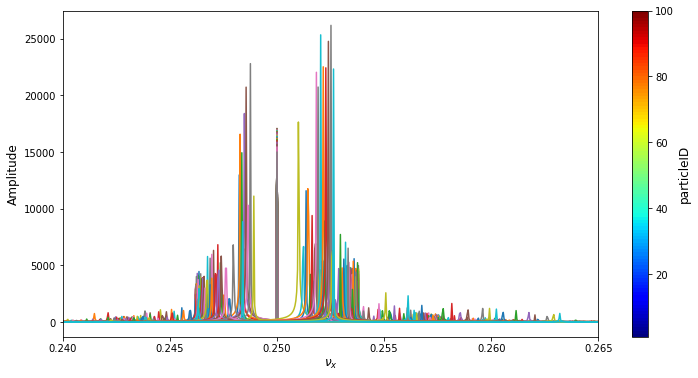

In [28]:
fig, ax = plt.subplots(figsize=(12,6))

n=100
cmap = mpl.cm.get_cmap('jet', n)

# colorbar setup
dummie_cax = ax.scatter(range(1,n+1), range(1,n+1), c=range(1,n+1), cmap=cmap)

freq = np.fft.fftfreq(25000)

for i, g in pdata.groupby("particleID"):
    df = g
    sp = np.fft.fft(df.x)
    ax.plot(freq,abs(sp.real))
    
plt.xlim(0.24,0.265)
plt.xlabel(r"$\nu_x$", fontsize=12)
plt.ylabel(r"Amplitude",fontsize=12)
cb =plt.colorbar(dummie_cax, label="ParticleID")
cb.set_label("particleID",fontsize=12)
# plt.savefig("FFT.png")

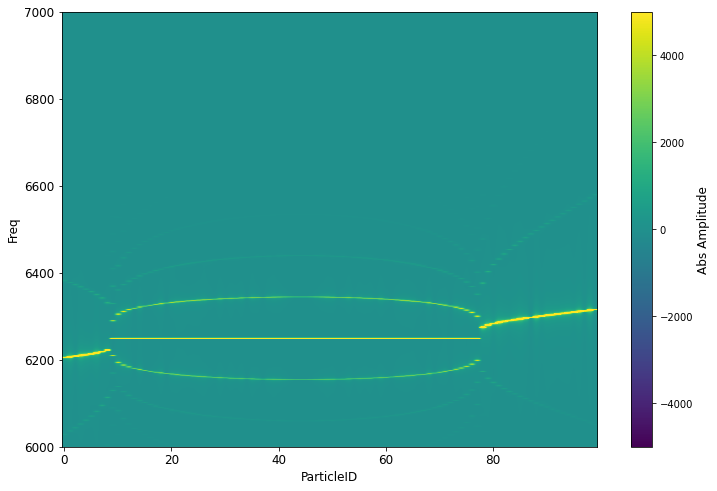

In [59]:
x = pdata.x.values.copy()
x = x.reshape(25000, 100)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=5000, vmin=-5000)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
plt.ylim(6000,7000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("FreqWaterFall_zoomed.png")

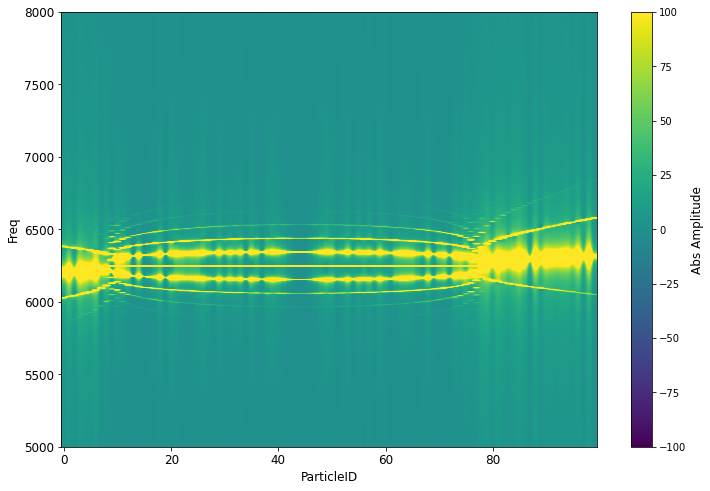

In [60]:
x = pdata.x.values.copy()
x = x.reshape(25000, 100)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=100, vmin=-100)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
plt.ylim(5000,8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("FreqWaterFall.png")

(array([5000., 5500., 6000., 6500., 7000., 7500., 8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

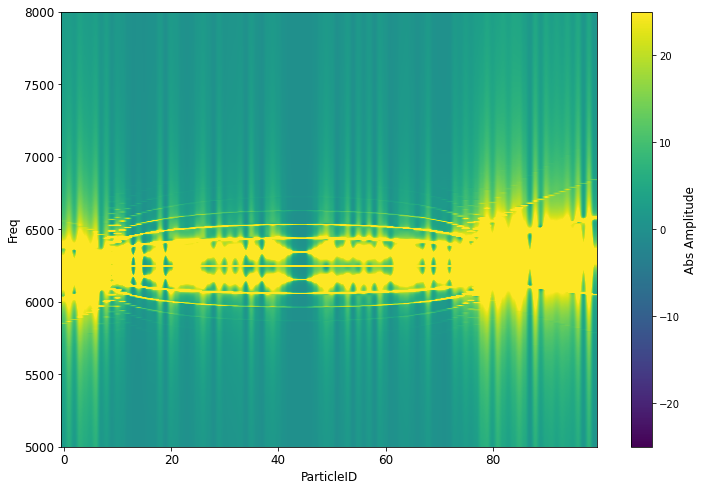

In [62]:
contrast = 25
x = pdata.x.values.copy()
x = x.reshape(25000, 100)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=contrast, vmin=-contrast)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
plt.ylim(5000,8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)